# Comparison of clustering methods for Single-Cell RNA-seq Data

## Introduction:
### Background
Single Cell Classification is a sem- computational method used to classify cells based on transcriptomics. The method functions off of the core principle that in eukaryotic, or multi celled, organisms, cells will specialize based on tissue type and desired function. While all cells have the same DNA, based on chromatin modeling, cells will express different genes. For example, one of the most prominent genes in muscle is MYOD1, which functions by producing myosin, a protein that is critical in elongating cells into microtubules (muscle fibers). As no other cell needs to take this shape, MYOD1 is only expressed in skeletal muscles. 
	Scientists can use this concept to identify cells based on the unique genes that they express. To do so, when a sample of tissue is collected, each cell’s mRNA (the template for protein formation that is transcribed from DNA) is ‘tagged’ with a specific primer called a UMI (unique molecular identifier). This way, when all mRNAs are sequenced together, scientists are able to sort which mRNA came from which cell. 
	In the data, this looks like AAACCCAAGGCGACAT_1 where “AAACCCAAGGCGACAT” is a unique (and random) set of nucleotides used to identify a certain cell in patient 1’s biopsy. The “_1” denotes which patient the cell came from. 
	It is important to note that not all cells, not all patients will have the same levels of gene expression. There could be a series of other (confounding) factors to consider that may differentiate one patient's biopsy from another. In some cases, like age, race, or collection method, there confounding factors add noise to the dataset that may cause false classifications. To address these concerns, we utilized standard quality control (QC) and standardization methods of Single-Cell Analysis. Context on these steps can be found in A practical guide to single-cell RNA-sequencing for biomedical research and clinical applications. 
	In practice, these datasets are high dimension and computationally expensive, with a single end to end sequence using a package such as seurat or scanpy taking upwards of 3 hours for a dataset of this size. In addition, the model has low generalizability and even lower explainability. This means that all cofounders have to be pre-normalized for, and large deconvolution work post-clustering must be performed to find determinate genes. 

### Hypothesis and Goals
Thus, we are hoping to test a series of classification models against the T-SNE classification that is standard practice in packages such as seurat and scanpy. Our design will be to use LDA and KNN models to classify each cell based on a normalized subset of differentially expressed genes. As the paper did not include a wet-lab classification of each cell (such as flow cytometry) our target clusters (that we will use to train on) will be the targets found via clustering analysis from standard practice packages (scanpy). From these clusters, we will be assessing accuracy on the ability to use the clusters themselves as features in logistic regression to classify a patient as smoking or nonsmoking

# Dataset 
Our dataset was sourced from the Single-Cell Expression Atlas, a repository for Single-Cell RNAseq data from scientific publications. The dataset we used was sourced from Goldfarbmuren et. Al in his publication Dissecting the cellular specificity of smoking effects and reconstructing lineages in the human airway epithelium. In this publication, the lung epithelial tissue of 15 donors with varying levels of habitual smoking classified as heavy, light, and never, were sequenced via bulk RNAseq. Reads were sequenced vis illumina RNAseq and mapped to the hg38 human genome. Low quality reads were dropped.


### Code imports
I removed the Luidenalg clustering package because it is a bit arduous to install and can cause errors. If you wish to perform the clustering in your own computer, see the documentation on instillation

- https://pypi.org/project/leidenalg/

In [1]:
# These packages are pre-installed on Google Colab, but are included here to facilitate running this notebook locally
!pip install --quiet matplotlib
!pip install --quiet scikit-learn
!pip install --quiet numpy
!pip install --quiet scipy
!pip install --quiet scanpy
!pip install --quiet anndata


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
# Import packages
import anndata
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.decomposition import TruncatedSVD
from scipy import sparse, io

### Data
Import each of the reads tables for each patient. Each table has N x M rows and columns where N is the number of genes detected, and M are the number of UMIs (or cells) sequenced.

In [3]:
T84 = pd.read_table("data/individual_counts/T84_invivo_expression_matrix.txt", sep="\t")
T85 = pd.read_table("data/individual_counts/T85_invivo_expression_matrix.txt", sep="\t")
T89 = pd.read_table("data/individual_counts/T89_invivo_expression_matrix.txt", sep="\t")
T120 = pd.read_table("data/individual_counts/T120_invivo_expression_matrix.txt", sep="\t")
T121 = pd.read_table("data/individual_counts/T121_invivo_expression_matrix.txt", sep="\t")
T126 = pd.read_table("data/individual_counts/T126_invivo_expression_matrix.txt", sep="\t")
T137 = pd.read_table("data/individual_counts/T137_invivo_expression_matrix.txt", sep="\t")
T90 = pd.read_table("data/individual_counts/T90_invivo_expression_matrix.txt",  sep="\t")
T101 = pd.read_table("data/individual_counts/T101_invivo_expression_matrix.txt",  sep="\t")
T153 = pd.read_table("data/individual_counts/T153_invivo_expression_matrix.txt", sep="\t")
T154 = pd.read_table("data/individual_counts/T154_invivo_expression_matrix.txt", sep="\t")
T164 = pd.read_table("data/individual_counts/T164_invivo_expression_matrix.txt", sep="\t")
T165 = pd.read_table("data/individual_counts/T165_invivo_expression_matrix.txt", sep="\t")
T166 = pd.read_table("data/individual_counts/T166_invivo_expression_matrix.txt", sep="\t")
T167 = pd.read_table("data/individual_counts/T167_invivo_expression_matrix.txt", sep="\t")


### EDA and Summary Statistics
Each sample was scanned for mitochondrial genes, ribosomal genes, and number of cells. To prevent the occurrence of potential doublets and nonspecific genes such as mitochondrial and ribosomal genes influencing classification. Cells lying outside the range of 1 < n_Genes < 99 percentile for each sample were dropped. 


In [4]:
# Sample names
namesVec = ["T101", "T120", "T121", "T126", "T137", "T153", "T154", "T164", "T165", "T166", "T167", "T84", "T85", "T89", "T90"]
dfs = {}

# Reading each sample into a DataFrame and storing it in a dictionary
for name in namesVec:
    filename = 'data/individual_counts/' + name + "_invivo_expression_matrix.txt"
    df = pd.read_csv(filename, sep="\t", header=0)
    dfs[name] = df


#### Step 2: Making summary stats table for each sample

In [5]:
sumTabList = []

for name, df in dfs.items():
    summary_df = pd.DataFrame(index=df.columns, columns=["ID", "nUMI", "nGene", "propMT"])
    summary_df["ID"] = df.columns
    summary_df["nUMI"] = df.sum()
    summary_df["nGene"] = (df != 0).sum()
    mtGenes = df.index[df.index.str.contains("^MTAT|^MT-|^MTCO|^MTCY|^MTERF|^MTND|^MTRF|^MTRN|^MRPL|^MRPS")]
    summary_df["propMT"] = df.loc[mtGenes].sum() / summary_df["nUMI"]
    sumTabList.append(summary_df)




#### Step 3: Exporting summary tables

In [6]:
for i, df in enumerate(sumTabList):
    df.to_csv('10X_T15_summaryStats' + namesVec[i] + '.csv')

#### Step 4: Histograms of summary stats (separate)

In [7]:
# Function for equal size bins
def bins(x):
    return np.concatenate([np.arange(min(x), max(x), 200), [max(x)]])

# Plotting histograms
for i, df in enumerate(sumTabList):
    plt.figure()
    plt.hist(df["nGene"], bins=bins(df["nGene"]), color="black")
    plt.axvline(np.quantile(df["nGene"], 0.99), color="red")
    plt.axvline(1500, color="red")
    plt.xlabel("Number of genes")
    plt.ylabel("")
    plt.title(namesVec[i])
    plt.savefig(f"data/histograms/10X_T15_nGene_hist_{namesVec[i]}.pdf")
    plt.close()


for i, df in enumerate(sumTabList):
    plt.figure()
    plt.hist(df["nUMI"], bins=bins(df["nUMI"]), color="black")
    plt.axvline(np.quantile(df["nUMI"], 0.99), color="red")
    plt.xlabel("Number of UMIs")
    plt.ylabel("")
    plt.title(namesVec[i])
    plt.savefig(f"data/histograms/10X_T15_nUMI_hist_{namesVec[i]}.pdf")
    plt.close()

for i, df in enumerate(sumTabList):
    plt.figure()
    plt.hist(df["propMT"], bins=bins(df["propMT"]), color="black")
    plt.axvline(0.3, color="red")
    plt.xlabel('Proportion MT genes')
    plt.ylabel("")
    plt.title(namesVec[i])
    plt.savefig(f"data/histograms/10X_T15_propMT_hist_{namesVec[i]}.pdf")
    plt.close()



#### Step 5: Filtering out cells, merging datasets, and filtering out genes

In [8]:


# Identifying cells to remove
removeList = {}
for name, df in dfs.items():
    removeList[name] = df.columns[(sumTabList[namesVec.index(name)]["nGene"] > np.quantile(sumTabList[namesVec.index(name)]["nGene"], 0.99)) |
                                  (sumTabList[namesVec.index(name)]["nGene"] < 1500) |
                                  (sumTabList[namesVec.index(name)]["nUMI"] > np.quantile(sumTabList[namesVec.index(name)]["nUMI"], 0.99)) |
                                  (sumTabList[namesVec.index(name)]["propMT"] > 0.3)].tolist()

# Also remove non-epithelial cells
removedCells = pd.read_csv("data/removedCells_scTransform_3000Features.txt", header=None).squeeze("columns")

for i, name in enumerate(namesVec):
    currRemovedCells = removedCells[removedCells.str.contains(f"_{i+1}$")].str.split("_").str[0].unique().tolist()
    to_rmv = set(currRemovedCells).intersection(dfs[name].columns)
    removeList[name].extend(to_rmv)
    
# Filter out samples
dfs_filtered = {}

i = 1

for name, df in dfs.items():
    dfs_filtered[name] = df.drop(columns=removeList[name])
    dfs_filtered[name].columns = list(map(lambda name: str(name) + "_" + str(i), list(dfs_filtered[name].columns)))
    i += 1



#### Summary of data QC
  after data cleaning manually, we are left with about 60% of cells from initial sample. This is pretty good conservation and demonstrates effective wet lab technique. 

In [9]:
# print out the number of dropped cells
dropped_cells_df = pd.DataFrame(index=namesVec, columns=['OriginalCellCount', "RemovedCellCount", 'NewCellCount', 'ProportionRemoved'])

dropped_cells_df["OriginalCellCount"] = list(map(lambda name: len(dfs[name].columns), namesVec))

dropped_cells_df["RemovedCellCount"] = list(map(lambda name: len(removeList[name]), namesVec))

dropped_cells_df["NewCellCount"] = list(map(lambda name: len(dfs_filtered[name].columns), namesVec))

dropped_cells_df["ProportionRemoved"] = dropped_cells_df["RemovedCellCount"] / dropped_cells_df["OriginalCellCount"]


In [10]:
dropped_cells_df

,OriginalCellCount,RemovedCellCount,NewCellCount,ProportionRemoved
T101,5834,2543,3295,0.435893
T120,1888,89,1799,0.047140
T121,1555,124,1431,0.079743
T126,1908,122,1786,0.063941
T137,1471,126,1345,0.085656
T153,5565,2131,3434,0.382929
T154,3676,2029,1650,0.551959
T164,5650,2406,3247,0.425841
T165,4835,2724,2118,0.563392
T166,6167,3548,2627,0.575320


### Making Combined Dataset
Each cell was tagged with a number _1 - _15 based on the patient it was sampled from. Remaining cells from all samples were merged, filtered for mitochondrial and ribosomal genes, and cells with no data. 
The published metadata file was used to align confounding factors such as smoking status of the patient to each cell.
Cells are aggregated to one datafile so they can be clustered under one model. This increases generalizability, and more robustly normalizes the data as the number of instances (m = cell_count) is higher.

#### Combine each dataframe with tagged samples (_1-_15)

In [11]:
combined_df = pd.concat(dfs_filtered.values(), axis=1)
combined_df = combined_df.loc[~combined_df.index.str.contains("^MTAT|^MT-|^MTCO|^MTCY|^MTERF|^MTND|^MTRF|^MTRN|^MRPL|^MRPS|^RPL|^RPS")]
combined_df = combined_df.loc[combined_df.sum(axis=1) != 0]

In [12]:
combined_df.shape

(34656, 35618)

#### Load in metadata
  This metadata file will contain confounding factors such as age, as well as the clusters that were discovered by Goldfarbmuren et. Al. These will serve as our clustering targets 

In [13]:
metadata = pd.read_csv("data/Metadata.tsv", delimiter="\t")
print(metadata.head())

                   donor  smoke smoke_noT89 clusters_10 clusters_16a
AAACCCAAGGCGACAT_1  T101  heavy       heavy          c2           c2
AAACCCAGTACTCGAT_1  T101  heavy       heavy          c3          c3a
AAACCCAGTATGTGTC_1  T101  heavy       heavy          c4           c4
AAACCCAGTTAGCGGA_1  T101  heavy       heavy          c4           c4
AAACCCAGTTGCCGAC_1  T101  heavy       heavy          c1           c1


to ensure index alignment, we joined the two dataframes on the cell codes.

In [14]:
temp_df = pd.merge(combined_df.T, metadata, left_index=True, right_index=True)

In [15]:
metadata = temp_df[list(metadata.columns)]
combined_df = temp_df.drop(labels = list(metadata.columns), axis = 1)

In [16]:
eda_df = metadata[["donor", 'smoke']]
eda_df.drop_duplicates()


,donor,smoke
AAACCCAAGGCGACAT_1,T101,heavy
AAACCTGAGAGTGACC_2,T120,heavy
AAACCTGAGGATGGTC_3,T121,light
AAACCTGAGGGAAACA_4,T126,never
AAACCTGAGACCCACC_5,T137,never
AAACCCAAGGGATCAC_6,T153,never
AAACCCACAAGGCCTC_7,T154,heavy
AAACCCACACTCCGAG_8,T164,never
AAACCCACACACACGC_9,T165,never
AAACCCATCAAGAAAC_10,T166,never


In [17]:
print("Number of cells from each donor")
metadata.groupby(["donor"]).count()

Number of cells from each donor


,smoke,smoke_noT89,clusters_10,clusters_16a
donor,,,,
T101,3295,3295,3295,3295
T120,1786,1786,1786,1786
T121,1419,1419,1419,1419
T126,1775,1775,1775,1775
T137,1332,1332,1332,1332
T153,3434,3434,3434,3434
T154,1650,1650,1650,1650
T164,3247,3247,3247,3247
T165,2118,2118,2118,2118


### Dealing with missing Values:
	Like most datasets, there were NaN values. These occur when merging the data frames together, as some donor did not express any of these genes. Because we know that missing values come from lack of detection, the mRNA count for that cell and that mRNA is effectively zero. Thus, we can input the data by filling all missing mRNA count values with zero. IN most cases, genes that were not detected across all donors were lowly detected in the donors in which they are present, and will be dropped when we select features. 


In [18]:
combined_df = combined_df.fillna(0)

## Scanpy Pre-processing and Feature Selection
Cells were normalized and clustered via the standard scanpy pipeline. We did this because there are under the hood data structures that help organize the data, as well as standardize for confounding factors when the data is normalized. The standard pipeline includes…

### filter samples (cells) on low expression 

In [19]:

# Create AnnData object
adata = sc.AnnData(X=combined_df, obs=metadata)

# filter out genes that are expressed in fewer than 1% of cells
print(adata.n_vars)
sc.pp.filter_genes(adata, min_cells=.01 * len(adata.obs_names))
print(adata.n_vars)

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=3000)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata)
sc.tl.umap(adata)



34656
16415


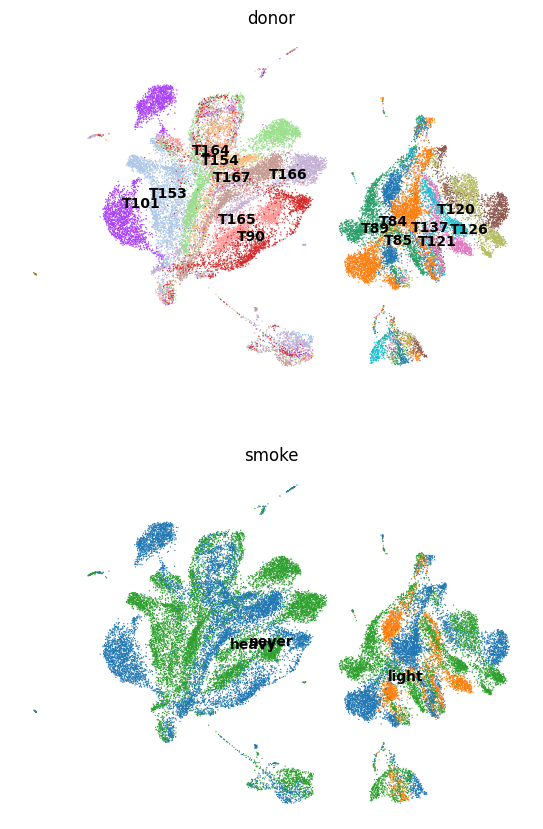

In [20]:
# Plot UMAP
sc.pl.umap(adata, color=['donor', 'smoke'], legend_loc='on data', frameon=False, ncols=1)

"""# Run clustering
sc.tl.leiden(adata, resolution=0.22) # about two Hours

# Plot UMAP with clustering results
sc.pl.umap(adata, color='leiden', legend_loc='on data', frameon=False, ncols=1)"""

# Save the result
adata.write("T15_processed.h5ad")

In [21]:
imp_genes = pd.DataFrame(adata.var.highly_variable)

In [22]:
imp_genes = imp_genes[imp_genes["highly_variable"] == True]

In [23]:
imp_genes

,highly_variable
HES4,True
ISG15,True
TTLL10,True
CFAP74,True
MORN1,True
...,...
C21orf59,True
ATP5O,True
AP000692.10,True
DSCR3,True


In [24]:
feat_sel_df = pd.DataFrame(adata.X, columns = adata.var_names, index = adata.obs_names)

In [25]:
feat_sel_df.head(30)

,AL669831.5,LINC00115,FAM41C,NOC2L,KLHL17,PLEKHN1,PERM1,AL645608.8,HES4,ISG15,...,CH507-9B2.5,CH507-42P11.8,CH507-254M2.3,AP001347.6,ATP5J,C21orf59,ATP5O,AP000692.10,DSCR3,C21orf33
AAACCCAAGGCGACAT_1,-0.250467,-0.202983,-0.306720,-0.912005,-0.187892,-0.422083,-0.126361,-0.280645,-0.245342,-0.654464,...,-0.113451,-0.145029,-0.094676,-0.097025,-0.725331,-0.428374,-0.739072,-0.115149,-0.28135,-0.218466
AAACCCAGTACTCGAT_1,-0.250467,-0.202983,-0.306720,-0.912005,-0.187892,-0.422083,-0.126361,-0.280645,0.663890,-0.654464,...,-0.113451,-0.145029,-0.094676,-0.097025,-0.725331,-0.428374,-0.739072,-0.115149,-0.28135,-0.218466
AAACCCAGTATGTGTC_1,-0.250467,-0.202983,-0.306720,-0.912005,-0.187892,-0.422083,-0.126361,9.753117,-1.124862,-0.654464,...,-0.113451,-0.145029,-0.094676,-0.097025,-0.725331,-0.428374,-0.739072,-0.115149,-0.28135,-0.218466
AAACCCAGTTAGCGGA_1,4.215841,-0.202983,-0.306720,-0.112999,-0.187892,-0.422083,-0.126361,-0.280645,1.484936,0.113054,...,-0.113451,-0.145029,-0.094676,-0.097025,-0.725331,-0.428374,-0.739072,-0.115149,-0.28135,-0.218466
AAACCCAGTTGCCGAC_1,-0.250467,-0.202983,-0.306720,0.562381,-0.187892,-0.422083,-0.126361,-0.280645,1.202926,-0.191326,...,-0.113451,-0.145029,-0.094676,-0.097025,-0.725331,-0.428374,-0.739072,-0.115149,-0.28135,-0.218466
AAACCCATCTTTCTAG_1,-0.250467,-0.202983,-0.306720,-0.912005,-0.187892,1.007195,-0.126361,-0.280645,0.254015,0.176600,...,-0.113451,-0.145029,-0.094676,-0.097025,-0.725331,-0.428374,-0.739072,-0.115149,-0.28135,-0.218466
AAACGAAAGTCAATCC_1,-0.250467,3.075855,-0.306720,0.699849,-0.187892,-0.422083,-0.126361,-0.280645,-1.124862,-0.654464,...,-0.113451,-0.145029,-0.094676,-0.097025,-0.725331,-0.428374,-0.739072,-0.115149,-0.28135,-0.218466
AAACGAAGTCCGGACT_1,-0.250467,-0.202983,3.715079,0.120069,-0.187892,-0.422083,-0.126361,-0.280645,-1.124862,-0.654464,...,-0.113451,-0.145029,-0.094676,-0.097025,-0.725331,-0.428374,-0.739072,-0.115149,-0.28135,-0.218466
AAACGAAGTCGTGTTA_1,-0.250467,-0.202983,-0.306720,1.078223,-0.187892,-0.422083,-0.126361,2.275891,1.148576,0.210389,...,-0.113451,-0.145029,-0.094676,-0.097025,-0.725331,-0.428374,-0.739072,-0.115149,-0.28135,-0.218466
AAACGAATCCGTGTAA_1,-0.250467,-0.202983,-0.306720,-0.912005,-0.187892,-0.422083,-0.126361,-0.280645,0.223403,0.510606,...,-0.113451,-0.145029,-0.094676,-0.097025,-0.725331,-0.428374,-0.739072,-0.115149,-0.28135,-0.218466


In [26]:
feat_sel_df = feat_sel_df.filter(items = imp_genes.index)
feat_sel_df.head()

,HES4,ISG15,TTLL10,CFAP74,MORN1,HES5,TP73,ERRFI1,PIK3CD-AS2,FBXO2,...,CH507-9B2.5,CH507-42P11.8,CH507-254M2.3,AP001347.6,ATP5J,C21orf59,ATP5O,AP000692.10,DSCR3,C21orf33
AAACCCAAGGCGACAT_1,-0.245342,-0.654464,-0.321928,-0.227773,-0.323629,-0.117457,1.059052,0.646571,1.693757,1.792633,...,-0.113451,-0.145029,-0.094676,-0.097025,-0.725331,-0.428374,-0.739072,-0.115149,-0.28135,-0.218466
AAACCCAGTACTCGAT_1,0.663890,-0.654464,-0.321928,-0.227773,-0.323629,-0.117457,1.648158,1.317635,-0.424334,1.509495,...,-0.113451,-0.145029,-0.094676,-0.097025,-0.725331,-0.428374,-0.739072,-0.115149,-0.28135,-0.218466
AAACCCAGTATGTGTC_1,-1.124862,-0.654464,-0.321928,-0.227773,-0.323629,-0.117457,-0.549411,0.751522,-0.424334,-0.836930,...,-0.113451,-0.145029,-0.094676,-0.097025,-0.725331,-0.428374,-0.739072,-0.115149,-0.28135,-0.218466
AAACCCAGTTAGCGGA_1,1.484936,0.113054,-0.321928,-0.227773,-0.323629,-0.117457,-0.549411,-0.227141,-0.424334,-0.209533,...,-0.113451,-0.145029,-0.094676,-0.097025,-0.725331,-0.428374,-0.739072,-0.115149,-0.28135,-0.218466
AAACCCAGTTGCCGAC_1,1.202926,-0.191326,-0.321928,-0.227773,-0.323629,1.949898,-0.549411,0.318160,-0.424334,-0.836930,...,-0.113451,-0.145029,-0.094676,-0.097025,-0.725331,-0.428374,-0.739072,-0.115149,-0.28135,-0.218466


In [27]:
pd.DataFrame(adata.obs).to_csv("metadata_of_normalized_and_feature_selected.csv")

In [28]:
feat_sel_df.to_csv("normalized_and_feature_selected.csv")

In [29]:
import pandas as pd
df = pd.read_csv("normalized_and_feature_selected.csv", index_col=0)
df.head()

,HES4,ISG15,TTLL10,CFAP74,MORN1,HES5,TP73,ERRFI1,PIK3CD-AS2,FBXO2,...,CH507-9B2.5,CH507-42P11.8,CH507-254M2.3,AP001347.6,ATP5J,C21orf59,ATP5O,AP000692.10,DSCR3,C21orf33
AAACCCAAGGCGACAT_1,-0.245342,-0.654464,-0.321928,-0.227773,-0.323629,-0.117457,1.059052,0.646571,1.693757,1.792633,...,-0.113451,-0.145029,-0.094676,-0.097025,-0.725331,-0.428374,-0.739072,-0.115149,-0.28135,-0.218466
AAACCCAGTACTCGAT_1,0.663890,-0.654464,-0.321928,-0.227773,-0.323629,-0.117457,1.648158,1.317635,-0.424334,1.509495,...,-0.113451,-0.145029,-0.094676,-0.097025,-0.725331,-0.428374,-0.739072,-0.115149,-0.28135,-0.218466
AAACCCAGTATGTGTC_1,-1.124862,-0.654464,-0.321928,-0.227773,-0.323629,-0.117457,-0.549411,0.751522,-0.424334,-0.836930,...,-0.113451,-0.145029,-0.094676,-0.097025,-0.725331,-0.428374,-0.739072,-0.115149,-0.28135,-0.218466
AAACCCAGTTAGCGGA_1,1.484936,0.113054,-0.321928,-0.227773,-0.323629,-0.117457,-0.549411,-0.227141,-0.424334,-0.209533,...,-0.113451,-0.145029,-0.094676,-0.097025,-0.725331,-0.428374,-0.739072,-0.115149,-0.28135,-0.218466
AAACCCAGTTGCCGAC_1,1.202926,-0.191326,-0.321928,-0.227773,-0.323629,1.949898,-0.549411,0.318160,-0.424334,-0.836930,...,-0.113451,-0.145029,-0.094676,-0.097025,-0.725331,-0.428374,-0.739072,-0.115149,-0.28135,-0.218466
